In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vtk_rw import read_vtk
import lmfit
import pandas as pd

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
colors = sns.color_palette('cubehelix', 10)

### Load data

In [4]:
hemi='lh'

mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_%s_d.vtk'%hemi
sulc_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_%s_d_sulc.npy'%hemi
mask_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/masks/%s_fullmask.npy'%hemi
embed_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/embed/connectivity/%s_smooth_3_embed_10.npy'%hemi
t1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/smooth_3/avg_%s_profiles_smooth_3.npy'%hemi

In [5]:
v,f,d = read_vtk(mesh_file)
mask = np.load(mask_file)
embedding = np.load(embed_file)
t1_profiles = np.load(t1_file)
sulc = np.load(sulc_file)

### Mask and average

In [6]:
t1_profiles[mask]=0
t1_avg = np.mean(t1_profiles[:,3:8], axis=1)

In [7]:
scatter_t1avg = np.delete(t1_avg, mask)
scatter_embed = np.delete(embedding, mask, axis=0)

t1_idx=np.where(scatter_t1avg<=1500)
scatter_t1avg = np.delete(scatter_t1avg, t1_idx)
scatter_embed = np.delete(scatter_embed, t1_idx, axis=0)

### Plot 2D histogramms

In [8]:
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.3)

In [9]:
fc_pos_mask = np.where(scatter_embed[:,0]<0)
fc_neg_mask = np.where(scatter_embed[:,0]>0)

scatter_embed_pos = np.delete(scatter_embed, fc_pos_mask, axis=0)
scatter_embed_neg = np.delete(scatter_embed, fc_neg_mask, axis=0)

scatter_t1avg_pos = np.delete(scatter_t1avg, fc_pos_mask)
scatter_t1avg_neg = np.delete(scatter_t1avg, fc_neg_mask)

In [10]:
t1_neg_mask = np.where(scatter_t1avg_neg<2000)
scatter_embed_neg_zoom = np.delete(scatter_embed_neg, t1_neg_mask, axis=0)
scatter_t1avg_neg_zoom = np.delete(scatter_t1avg_neg, t1_neg_mask)

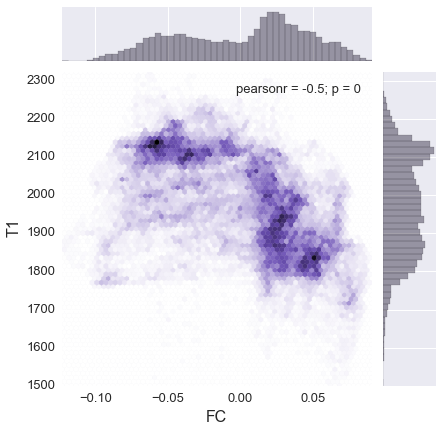

In [11]:
g = sns.jointplot(scatter_embed[:,0], scatter_t1avg, kind="hex", size=6, color=colors[0])
g.set_axis_labels('FC', 'T1', fontsize=16)

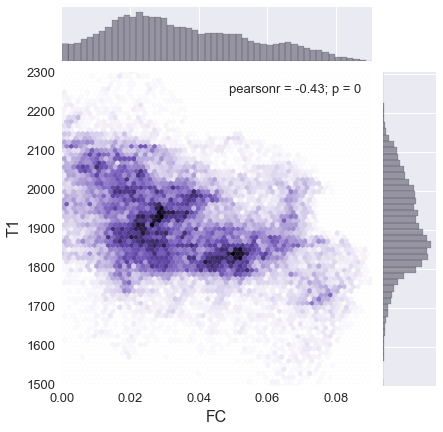

In [12]:
g = sns.jointplot(scatter_embed_pos[:,0], scatter_t1avg_pos, kind="hex", size=6, color=colors[0])
g.set_axis_labels('FC', 'T1', fontsize=16)

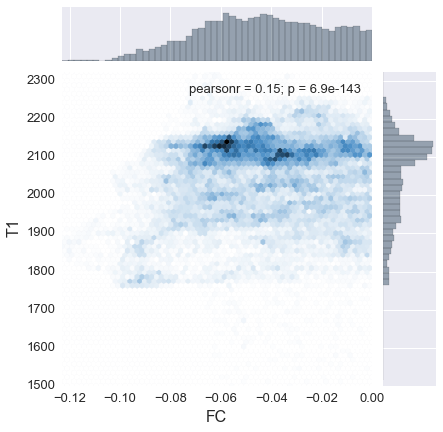

In [26]:
g = sns.jointplot(scatter_embed_neg[:,0], scatter_t1avg_neg, kind="hex", size=6, color=colors[1])
g.set_axis_labels('FC', 'T1', fontsize=16)

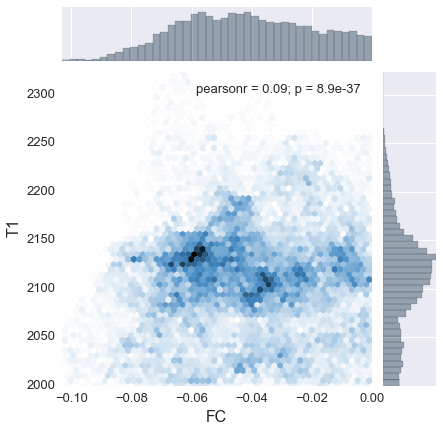

In [27]:
g = sns.jointplot(scatter_embed_neg_zoom[:,0], scatter_t1avg_neg_zoom, kind="hex", size=6, color=colors[1])
g.set_axis_labels('FC', 'T1', fontsize=16)

In [22]:
print 'T1 avg for pos embedding part', np.mean(scatter_t1avg_pos), np.std(scatter_t1avg_pos)
print 'T1 avg for neg embedding part', np.mean(scatter_t1avg_neg), np.std(scatter_t1avg_neg)

T1 avg for pos embedding part 1910.00627684 112.802236685
T1 avg for neg embedding part 2044.98703885 114.389532934


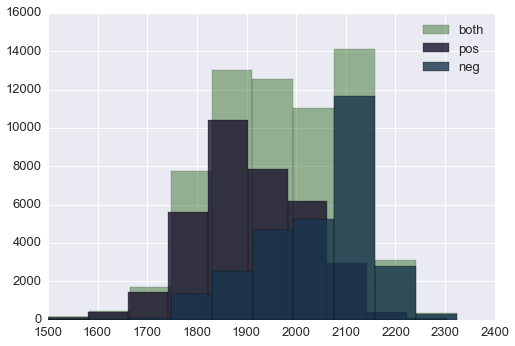

In [36]:
plt.hist(scatter_t1avg,alpha=0.5, color=colors[3], label='both')
plt.hist(scatter_t1avg_pos,alpha=0.8, color=colors[0], label='pos')
plt.hist(scatter_t1avg_neg,alpha=0.8, color=colors[1], label='neg')
plt.legend()

In [28]:
import scipy.stats as stats

In [30]:
stats.ttest_ind(scatter_t1avg_neg, scatter_t1avg_pos)

Ttest_indResult(statistic=149.90423785954465, pvalue=0.0)

### Normalize data to get sensible model comparison

"Note that the calculation of chi-square and reduced chi-square assume that the returned residual function is scaled properly to the uncertainties in the data. For these statistics to be meaningful, the person writing the function to be minimized must scale them properly."

Is this valid, given the data are not normally distributed? 

In [12]:
t1_norm = (scatter_t1avg - np.mean(scatter_t1avg)) / (np.std(scatter_t1avg))
r1_norm = (scatter_r1avg - np.mean(scatter_r1avg)) / (np.std(scatter_r1avg))
embed1_t1_norm = (scatter_embed_t1[:,0] - np.mean(scatter_embed_t1[:,0])) / (np.std(scatter_embed_t1[:,0]))
embed1_r1_norm = (scatter_embed_r1[:,0] - np.mean(scatter_embed_r1[:,0])) / (np.std(scatter_embed_r1[:,0]))

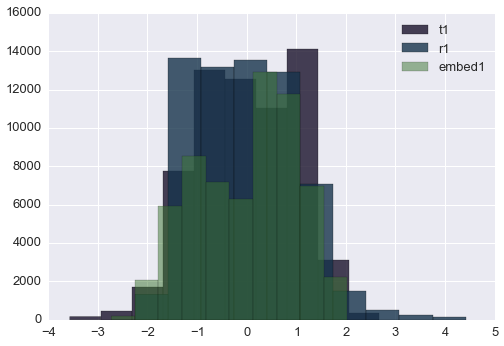

In [13]:
plt.hist(t1_norm, alpha=0.8, color=colors[0], label='t1');
plt.hist(r1_norm, alpha=0.8, color=colors[1], label='r1');
#plt.hist(embed1_t1_norm, alpha=0.7, color=colors[2], label='embed1_t1');
plt.hist(embed1_r1_norm, alpha=0.5, color=colors[3], label='embed1');
plt.legend()

### Model

In [14]:
def custom_plot(x, y, res, xlabel=None, ylabel=None, data_color=colors[1]):
    fig=plt.figure(figsize=(12,5))
    fig.add_subplot(121)
    plt.plot(x, y, alpha=0.1, marker='.', linestyle='None', color=data_color)
    plt.plot(x, res.best_fit, color='black', linestyle='None', marker='.', markersize=.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    fig.add_subplot(122)
    res.plot_residuals(data_kws={'alpha':0.1, 'color':'grey', 'marker':'.'}, fit_kws={'color':'k', 'linewidth':2})
    
def custom_report(res, label):
    print '##### %s #####'%label
    print res.fit_report()
    print 'BIC', res.bic
    print 'AIC', res.aic
    print ''

In [15]:
def fit_simple(model, x, y, t1type, xlabel, ylabel, color):
    
    pars = model.guess(y, x=x)
    out = model.fit(y, pars, x=x)
    
    custom_report(out, t1type)
    custom_plot(x,y, out, xlabel=xlabel, ylabel=ylabel, data_color=color)
    
    return out

In [16]:
def fit_composite_const(model, x, y, t1type, xlabel, ylabel, color):
    
    const_model = lmfit.models.LinearModel(prefix='const_')
    const_model.set_param_hint(name='slope', value=0, vary=False)
    comp_model = model + const_model
    
    pars = const_model.make_params(intercept=y.min())
    pars += model.guess(y, x=x)
    out = comp_model.fit(y, pars, x=x)
    
    custom_report(out, t1type)
    custom_plot(x,y, out, xlabel=xlabel, ylabel=ylabel, data_color=color)
    
    return out

### Linear fit

##### T1avg #####
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # function evals   = 5
    # data points      = 64304
    # variables        = 2
    chi-square         = 48225.664
    reduced chi-square = 0.750
[[Variables]]
    slope:      -0.50003632 +/- 0        (0.00%) (init=-0.5000363)
    intercept:   5.4355e-16 +/- 0        (0.00%) (init= 5.435481e-16)
[[Correlations]] (unreported correlations are <  0.100)

BIC -18478.0794234
AIC -18496.2221777

##### R1avg #####
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # function evals   = 5
    # data points      = 64113
    # variables        = 2
    chi-square         = 48568.352
    reduced chi-square = 0.758
[[Variables]]
    slope:       0.49239926 +/- 0        (0.00%) (init= 0.4923993)
    intercept:  -7.6315e-16 +/- 0        (0.00%) (init=-7.631523e-16)
[[Correlations]] (unreported correlations are <  0.100)

BIC -17778.4424455
AIC -17796.5792503



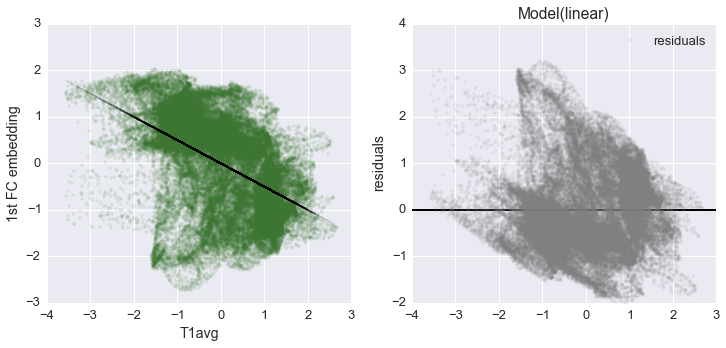

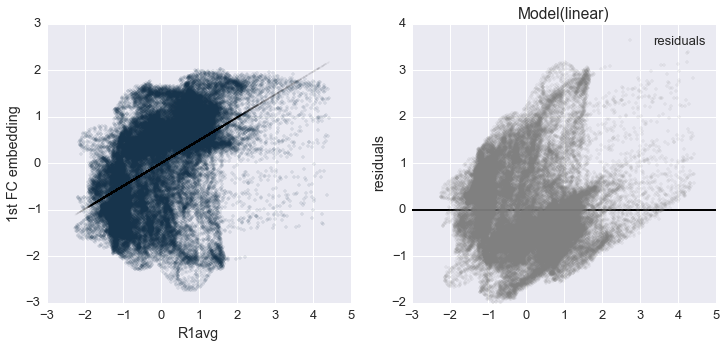

In [17]:
lin_mod = lmfit.models.LinearModel()

lin_t1 = fit_simple(lin_mod, 
                        x=t1_norm, y=embed1_t1_norm,
                        t1type='T1avg',
                        xlabel='T1avg',
                        ylabel='1st FC embedding', 
                        color=colors[3])


lin_r1 = fit_simple(lin_mod,
                        x=r1_norm, y=embed1_r1_norm, 
                        t1type='R1avg',
                        xlabel='R1avg',
                        ylabel='1st FC embedding', 
                        color=colors[1])

### Quadratic fit

##### T1avg #####
[[Model]]
    Model(parabolic)
[[Fit Statistics]]
    # function evals   = 6
    # data points      = 64304
    # variables        = 3
    chi-square         = 48113.020
    reduced chi-square = 0.748
[[Variables]]
    a:  -0.03558765 +/- 0.002900 (8.15%) (init=-0.03558766)
    b:  -0.50612122 +/- 0.003447 (0.68%) (init=-0.5061212)
    c:   0.03558765 +/- 0.004477 (12.58%) (init= 0.03558766)
[[Correlations]] (unreported correlations are <  0.100)
    C(a, c)                      = -0.648 
    C(a, b)                      =  0.144 

BIC -18616.3832956
AIC -18643.5974269

##### R1avg #####
[[Model]]
    Model(parabolic)
[[Fit Statistics]]
    # function evals   = 6
    # data points      = 64113
    # variables        = 3
    chi-square         = 47927.392
    reduced chi-square = 0.748
[[Variables]]
    a:  -0.07297236 +/- 0.002492 (3.42%) (init=-0.07297237)
    b:   0.52970464 +/- 0.003644 (0.69%) (init= 0.5297046)
    c:   0.07297237 +/- 0.004227 (5.79%) (init= 0.072

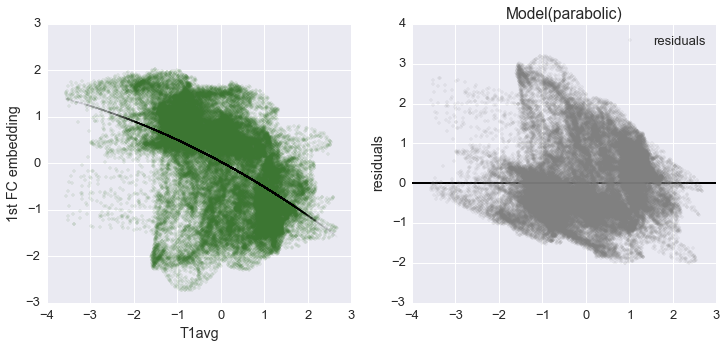

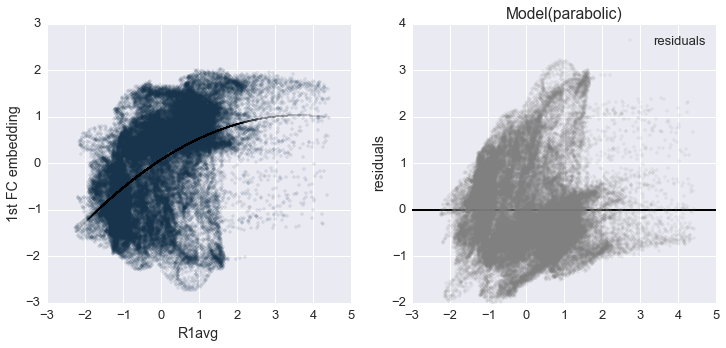

In [18]:
quad_mod = lmfit.models.QuadraticModel()

quad_t1 = fit_simple(quad_mod, 
                        x=t1_norm, y=embed1_t1_norm,
                        t1type='T1avg',
                        xlabel='T1avg',
                        ylabel='1st FC embedding', 
                        color=colors[3])


quad_r1 = fit_simple(quad_mod, 
                        x=r1_norm, y=embed1_r1_norm, 
                        t1type='R1avg',
                        xlabel='R1avg',
                        ylabel='1st FC embedding', 
                        color=colors[1])

### Polynomial model degree=3

##### T1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 7
    # data points      = 64304
    # variables        = 4
    chi-square         = 47926.536
    reduced chi-square = 0.745
[[Variables]]
    c0:   0.01573044 +/- 0.004641 (29.51%) (init= 0.01573045)
    c1:  -0.57272799 +/- 0.005437 (0.95%) (init=-0.572728)
    c2:  -0.01070804 +/- 0.003294 (30.77%) (init=-0.01070804)
    c3:   0.02937362 +/- 0.001857 (6.32%) (init= 0.02937362)
[[Correlations]] (unreported correlations are <  0.100)
    C(c1, c3)                    = -0.774 
    C(c0, c2)                    = -0.677 
    C(c2, c3)                    =  0.477 
    C(c1, c2)                    = -0.290 
    C(c0, c3)                    = -0.270 
    C(c0, c1)                    =  0.153 

BIC -18854.0354626
AIC -18890.3209711

##### R1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 7
    # data points      = 64113
    # variables        = 4
    chi-square

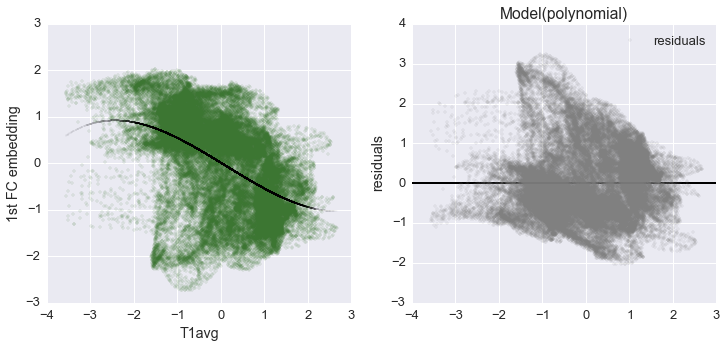

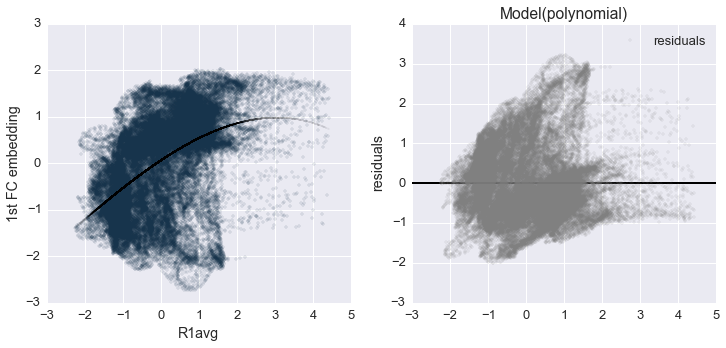

In [19]:
poly3_mod = lmfit.models.PolynomialModel(degree=3)

poly3_t1 = fit_simple(poly3_mod, 
                        x=t1_norm, y=embed1_t1_norm,
                        t1type='T1avg',
                        xlabel='T1avg',
                        ylabel='1st FC embedding', 
                        color=colors[3])


poly3_r1 = fit_simple(poly3_mod, 
                        x=r1_norm, y=embed1_r1_norm, 
                        t1type='R1avg',
                        xlabel='R1avg',
                        ylabel='1st FC embedding', 
                        color=colors[1])

### Polynomial fit degree=4

##### T1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 8
    # data points      = 64304
    # variables        = 5
    chi-square         = 47757.864
    reduced chi-square = 0.743
[[Variables]]
    c0:   0.05146618 +/- 0.005205 (10.11%) (init= 0.05146619)
    c1:  -0.61559451 +/- 0.006128 (1.00%) (init=-0.6155945)
    c2:  -0.08458564 +/- 0.005903 (6.98%) (init=-0.08458564)
    c3:   0.05471565 +/- 0.002502 (4.57%) (init= 0.05471566)
    c4:   0.01760695 +/- 0.001168 (6.64%) (init= 0.01760696)
[[Correlations]] (unreported correlations are <  0.100)
    C(c2, c4)                    = -0.830 
    C(c1, c3)                    = -0.820 
    C(c0, c2)                    = -0.714 
    C(c3, c4)                    =  0.672 
    C(c1, c4)                    = -0.464 
    C(c0, c4)                    =  0.456 
    C(c2, c3)                    = -0.361 
    C(c1, c2)                    =  0.242 
    C(c0, c3)                    =  0.128 

BIC -19068.673759

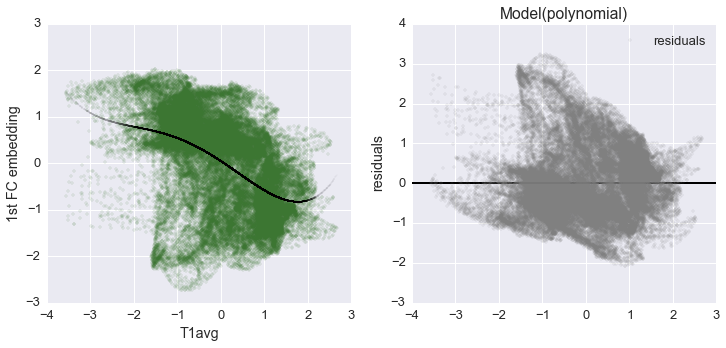

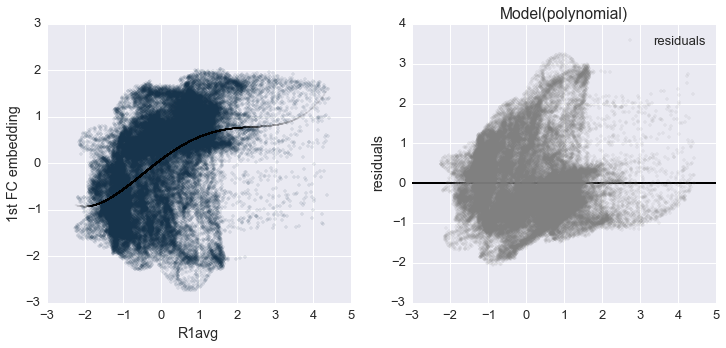

In [20]:
poly4_mod = lmfit.models.PolynomialModel(degree=4)

poly4_t1 = fit_simple(poly4_mod, 
                        x=t1_norm, y=embed1_t1_norm,
                        t1type='T1avg',
                        xlabel='T1avg',
                        ylabel='1st FC embedding', 
                        color=colors[3])


poly4_r1 = fit_simple(poly4_mod, 
                        x=r1_norm, y=embed1_r1_norm, 
                        t1type='R1avg',
                        xlabel='R1avg',
                        ylabel='1st FC embedding', 
                        color=colors[1])

### Polynomial fit degree=5

##### T1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 9
    # data points      = 64304
    # variables        = 6
    chi-square         = 47685.272
    reduced chi-square = 0.742
[[Variables]]
    c0:   0.07041862 +/- 0.005542 (7.87%) (init= 0.07041862)
    c1:  -0.56573196 +/- 0.007930 (1.40%) (init=-0.565732)
    c2:  -0.13155146 +/- 0.007571 (5.76%) (init=-0.1315515)
    c3:   0.00936076 +/- 0.005222 (55.79%) (init= 0.00936077)
    c4:   0.03140515 +/- 0.001818 (5.79%) (init= 0.03140516)
    c5:   0.00742348 +/- 0.000750 (10.11%) (init= 0.007423483)
[[Correlations]] (unreported correlations are <  0.100)
    C(c2, c4)                    = -0.896 
    C(c3, c5)                    = -0.878 
    C(c1, c3)                    = -0.861 
    C(c4, c5)                    =  0.767 
    C(c0, c2)                    = -0.739 
    C(c1, c5)                    =  0.635 
    C(c2, c5)                    = -0.627 
    C(c0, c4)                    =  0.539 


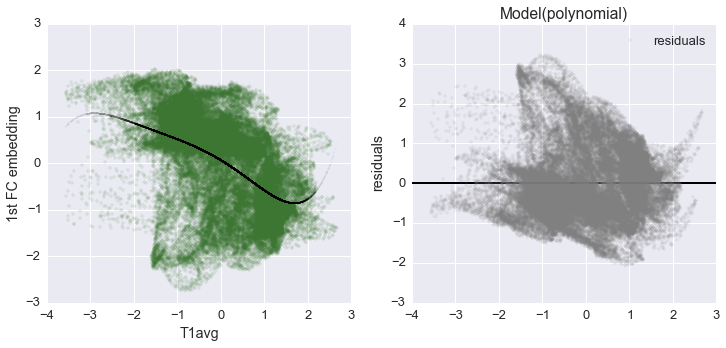

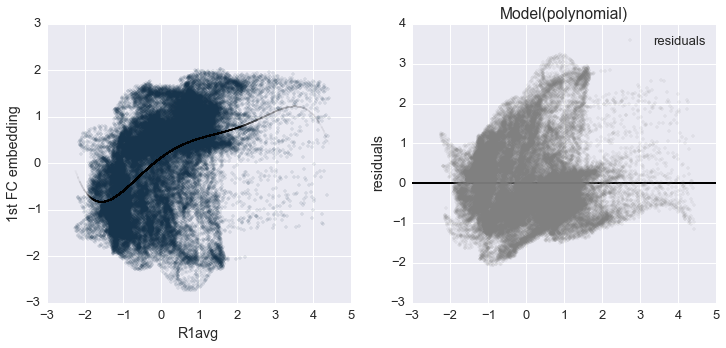

In [21]:
poly5_mod = lmfit.models.PolynomialModel(degree=5)

poly5_t1 = fit_simple(poly5_mod, 
                        x=t1_norm, y=embed1_t1_norm,
                        t1type='T1avg',
                        xlabel='T1avg',
                        ylabel='1st FC embedding', 
                        color=colors[3])


poly5_r1 = fit_simple(poly5_mod, 
                        x=r1_norm, y=embed1_r1_norm, 
                        t1type='R1avg',
                        xlabel='R1avg',
                        ylabel='1st FC embedding', 
                        color=colors[1])

### Polynomial fit degree=6

##### T1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 10
    # data points      = 64304
    # variables        = 7
    chi-square         = 47656.270
    reduced chi-square = 0.741
[[Variables]]
    c0:   0.08077635 +/- 0.005783 (7.16%) (init= 0.08077635)
    c1:  -0.60122161 +/- 0.009749 (1.62%) (init=-0.6012216)
    c2:  -0.17100954 +/- 0.009853 (5.76%) (init=-0.1710095)
    c3:   0.04788682 +/- 0.008073 (16.86%) (init= 0.04788683)
    c4:   0.05348443 +/- 0.003970 (7.42%) (init= 0.05348444)
    c5:   0.00037556 +/- 0.001353 (360.42%) (init= 0.0003755567)
    c6:  -0.00293515 +/- 0.000469 (15.99%) (init=-0.002935152)
[[Correlations]] (unreported correlations are <  0.100)
    C(c3, c5)                    = -0.950 
    C(c1, c3)                    = -0.897 
    C(c4, c6)                    = -0.889 
    C(c2, c4)                    = -0.884 
    C(c5, c6)                    =  0.832 
    C(c1, c5)                    =  0.771 
    C(c3, c6)      

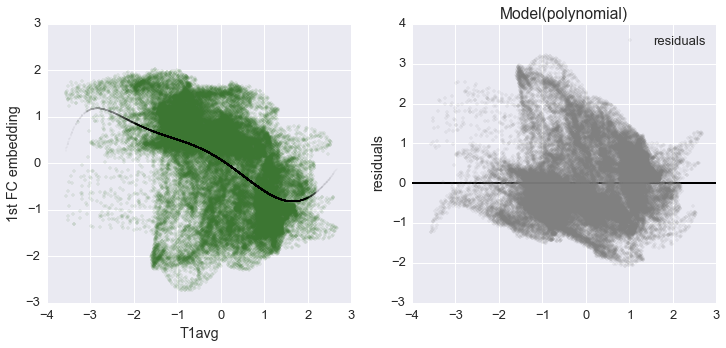

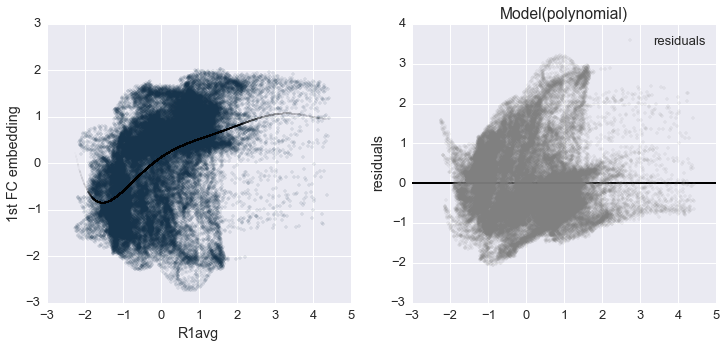

In [22]:
poly6_mod = lmfit.models.PolynomialModel(degree=6)

poly6_t1 = fit_simple(poly6_mod, 
                        x=t1_norm, y=embed1_t1_norm,
                        t1type='T1avg',
                        xlabel='T1avg',
                        ylabel='1st FC embedding', 
                        color=colors[3])


poly6_r1 = fit_simple(poly6_mod, 
                        x=r1_norm, y=embed1_r1_norm, 
                        t1type='R1avg',
                        xlabel='R1avg',
                        ylabel='1st FC embedding', 
                        color=colors[1])

### Polynomial fit degree=7

##### T1avg #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 11
    # data points      = 64304
    # variables        = 8
    chi-square         = 47584.807
    reduced chi-square = 0.740
[[Variables]]
    c0:   0.10308842 +/- 0.006209 (6.02%) (init= 0.1030884)
    c1:  -0.55479184 +/- 0.010827 (1.95%) (init=-0.5547918)
    c2:  -0.26572586 +/- 0.013778 (5.19%) (init=-0.2657259)
    c3:  -0.02133213 +/- 0.010710 (50.21%) (init=-0.02133213)
    c4:   0.11237279 +/- 0.007187 (6.40%) (init= 0.1123728)
    c5:   0.02663199 +/- 0.002994 (11.25%) (init= 0.026632)
    c6:  -0.01083456 +/- 0.000931 (8.59%) (init=-0.01083457)
    c7:  -0.00285442 +/- 0.000290 (10.18%) (init=-0.002854422)
[[Correlations]] (unreported correlations are <  0.100)
    C(c4, c6)                    = -0.968 
    C(c2, c4)                    = -0.932 
    C(c3, c5)                    = -0.910 
    C(c1, c3)                    = -0.895 
    C(c5, c7)                    = -0.892 
    C(c6

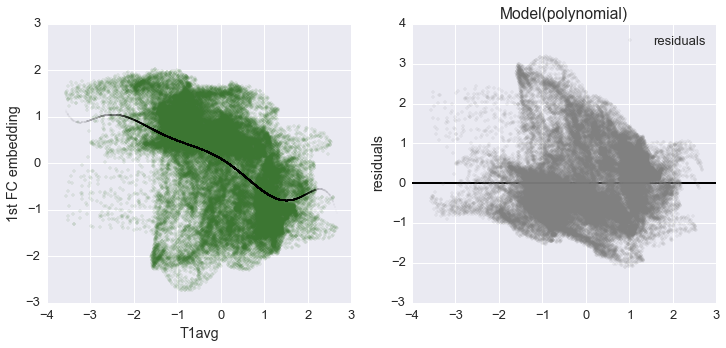

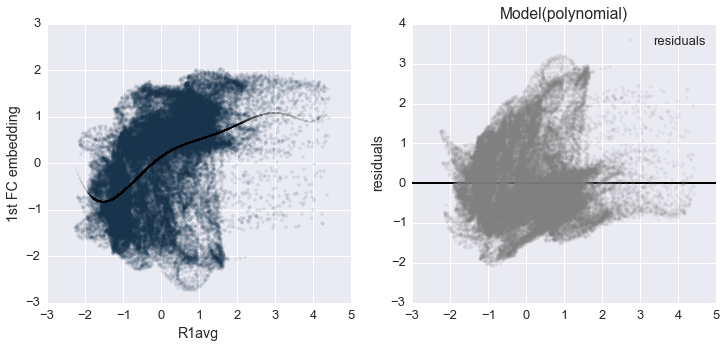

In [23]:
poly7_mod = lmfit.models.PolynomialModel(degree=7)

poly7_t1 = fit_simple(poly7_mod, 
                        x=t1_norm, y=embed1_t1_norm,
                        t1type='T1avg',
                        xlabel='T1avg',
                        ylabel='1st FC embedding', 
                        color=colors[3])


poly7_r1 = fit_simple(poly7_mod, 
                        x=r1_norm, y=embed1_r1_norm, 
                        t1type='R1avg',
                        xlabel='R1avg',
                        ylabel='1st FC embedding',  
                        color=colors[1])

### Linear step function with constant

In [24]:
step_lin_const_t1 = fit_composite_const(step_lin_mod,
                                        x=t1_norm, y=embed1_t1_norm,
                                        t1type='T1avg',
                                        xlabel='T1avg',
                                        ylabel='1st FC embedding', 
                                        color=colors[3])

step_lin_const_r1 = fit_composite_const(step_lin_mod, 
                                        x=r1_norm, y=embed1_r1_norm, 
                                        t1type='R1avg',
                                        xlabel='R1avg',
                                        ylabel='1st FC embedding', 
                                        color=colors[1])

NameError: name 'step_lin_mod' is not defined

### Arctan function + constant

In [ ]:
step_atan_mod = lmfit.models.StepModel(form='atan')

step_atan_const_t1 = fit_composite_const(step_atan_mod,
                                        x=t1_norm, y=embed1_t1_norm,
                                        t1type='T1avg',
                                        xlabel='T1avg',
                                        ylabel='1st FC embedding', 
                                        color=colors[3])

step_atan_const_r1 = fit_composite_const(step_atan_mod, 
                                        x=r1_norm, y=embed1_r1_norm, 
                                        t1type='R1avg',
                                        xlabel='R1avg',
                                        ylabel='1st FC embedding', 
                                        color=colors[1])

### Logistic function + constant

In [ ]:
step_log_mod = lmfit.models.StepModel(form='logistic')

step_log_const_t1 = fit_composite_const(step_log_mod,
                                        x=t1_norm, y=embed1_t1_norm,
                                        t1type='T1avg',
                                        xlabel='T1avg',
                                        ylabel='1st FC embedding',  
                                        color=colors[3])

step_log_const_r1 = fit_composite_const(step_log_mod, 
                                        x=r1_norm, y=embed1_r1_norm, 
                                        t1type='R1avg',
                                        xlabel='R1avg',
                                        ylabel='1st FC embedding', 
                                        color=colors[1])

### Error function + constant

In [ ]:
step_erf_mod = lmfit.models.StepModel(form='erf')

step_erf_const_t1 = fit_composite_const(step_erf_mod,
                                        x=t1_norm, y=embed1_t1_norm,
                                        t1type='T1avg',
                                        xlabel='T1avg',
                                        ylabel='1st FC embedding', 
                                        color=colors[3])

step_erf_const_r1 = fit_composite_const(step_erf_mod, 
                                        x=r1_norm, y=embed1_r1_norm, 
                                        t1type='R1avg',
                                        xlabel='R1avg',
                                        ylabel='1st FC embedding', 
                                        color=colors[1])

### Compare different models

In [ ]:
names = ['linear', 'quadratic', 'poly3', 'poly4', 'poly5', 'poly6', 'poly7', 
         'step lin', 'step atan', 'step log', 'step erf']

t1_results = [lin_t1, quad_t1, poly3_t1, poly4_t1, poly5_t1, poly6_t1, poly7_t1, 
                     step_lin_const_t1, step_atan_const_t1, step_log_const_t1, step_erf_const_t1]

r1_results = [lin_r1, quad_r1, poly3_r1, poly4_r1, poly5_r1, poly6_r1, poly7_r1, 
                     step_lin_const_r1, step_atan_const_r1, step_log_const_r1, step_erf_const_r1]

df = pd.DataFrame()

df['Value']=[m.bic for m in t1_results]+[m.aic for m in t1_results]+[m.bic for m in r1_results]+[m.aic for m in r1_results]
df['Model']=4*names
df['Criterion']=len(t1_results)*['BIC T1']+len(t1_results)*['AIC T1']+len(r1_results)*['BIC R1']+len(r1_results)*['AIC R1']


df2 = pd.DataFrame()

df2['Model'] = 2*names
df2['Datatype'] = len(names)*['T1']+len(names)*['R1']
df2['Chisqr'] = [m.chisqr for m in t1_results] + [m.chisqr for m in r1_results]
df2['Reduced Chi'] = [m.redchi for m in t1_results] + [m.redchi for m in r1_results]

In [ ]:
sns.set_context('notebook', font_scale=2)

fig=plt.figure(figsize=(20,10))
fig.add_subplot(121)
#sns.barplot(data=df, y='Model', x='Value', hue='Criterion', 
#            palette=[colors[2], colors[3], colors[5], colors[6]])
sns.pointplot(data=df, x='Model', y='Value', hue='Criterion', linewidth=0,
             palette=[colors[2], colors[3], colors[5], colors[6]])
plt.legend(loc=1, frameon=True)
plt.ylabel('BIC/AIC')
plt.xticks(rotation=45)

fig.add_subplot(122)
#sns.barplot(data=df2, y='Model', x='Reduced Chi', hue='Datatype', 
#            palette=[colors[3], colors[5]])
sns.pointplot(data=df2, x='Model', y='Chisqr', hue='Datatype', 
           palette=[colors[1], colors[7]])
plt.legend(loc=1, frameon=True)
plt.ylabel('Chisqr')
plt.xticks(rotation=45);

if hemi=='lh':
    hemistring='left'
elif hemi=='rh':
    hemistring='right'
else:
    hemistring='both'
plt.suptitle('FC explained by T1 %s'%hemistring, fontsize=25)

In [ ]:
t1_df = pd.DataFrame()
t1_df['Model']=names
t1_df['T1 BIC']=[m.bic for m in t1_results]
t1_df['T1 AIC']=[m.bic for m in t1_results]
t1_df['T1 Chisqr']=[m.chisqr for m in t1_results]
t1_df

In [ ]:
r1_df = pd.DataFrame()
r1_df['Model']=names
r1_df['R1 BIC']=[m.bic for m in r1_results]
r1_df['R1 AIC']=[m.bic for m in r1_results]
r1_df['R1 Chisqr']=[m.chisqr for m in r1_results]
r1_df